## Imports

In [ ]:
!pip install sklearn-crfsuite opencv-python torch matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install git+https://github.com/facebookresearch/sam2.git

In [6]:
# Download SAM/SAM2 checkpoints

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-10-15 22:46:28--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.10, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.1_hiera_large.pt’

sam2.1_hiera_large. 100%[===================>] 856.48M   228MB/s    in 3.8s    

2024-10-15 22:46:32 (224 MB/s) - ‘../checkpoints/sam2.1_hiera_large.pt’ saved [898083611/898083611]

--2024-10-15 22:46:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.10, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [ ]:
import os
import cv2
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm
from google.colab import drive
from sklearn_crfsuite import CRF
from skimage.color import label2rgb
from skimage.segmentation import slic

using_colab = True

# Dataset path
BASE_PATH = '/content/drive/MyDrive/data/jbg060_AI_for_Good_course_Shared'
REEFSUPPORT_PATH = os.path.join(BASE_PATH, '01_Data', 'benthic_datasets', 'mask_labels', 'reef_support')

## Connecting to the Google Drive Shortcuts


Before you run the cells bellow, make sure to make a google drive short cut to the [DBL Google Drive](https://drive.google.com/drive/u/0/folders/1JWr9SORKKmUjwQFYigekfVXpHwfEqNss)

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data loader

In [50]:
import os
import cv2
import albumentations
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm


class DataLoader:
    def __init__(
        self,
        data_folder,
        dataset_len_limit=None,
        sampling_size=100,
    ):
        self.data_folder = data_folder
        self.sampling_size = sampling_size
        self.img_paths = []
        self.mask_paths = []

        for sub_folder in os.listdir(self.data_folder):
            for img_path in os.listdir(os.path.join(self.data_folder, sub_folder, 'images')):
                self.img_paths.append(os.path.join(self.data_folder, sub_folder, 'images', img_path))
                self.mask_paths.append(os.path.join(self.data_folder, sub_folder, 'masks_stitched', img_path.replace('.JPG', '_mask.png')))

        if dataset_len_limit is not None:
            self.img_paths = self.img_paths[:dataset_len_limit]
            self.mask_paths = self.mask_paths[:dataset_len_limit]

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        --------
        int
            Number of samples in the dataset.
        """
        return len(self.img_paths)

    def __getitem__(self, idx):
        """
        Returns the image, mask, keypoints, and point labels for the given index.

        Parameters:
        -----------
        idx : int
            Index of the sample to retrieve.

        Returns:
        --------
        tuple
            A tuple containing the image, mask, keypoints, and point labels.
        """
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]

        img = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        mask = DataLoader.create_color_mask(mask)
        dot_coords, dot_labels = DataLoader.sample_points(mask, self.sampling_size)
        return img, mask, dot_coords, dot_labels

    @staticmethod
    def get_resize_transform(image_size=1024):
        """
        Creates a resizing transformation for images and masks to a specified size.

        Parameters:
        -----------
        image_size : int, optional
            Desired output size of the image and mask. Defaults to 1024.

        Returns:
        --------
        albumentations.Compose
            A composed transformation that resizes images and masks.
        """
        resize_transform = albumentations.Compose(
            [
                albumentations.Resize(
                    height=image_size,
                    width=image_size,
                    interpolation=cv2.INTER_AREA,
                    p=1,
                ),
            ]
        )
        return resize_transform

    @staticmethod
    def sample_points(mask, num_points):
        height, width = mask.shape
        y_coords = np.random.randint(0, height, num_points)
        x_coords = np.random.randint(0, width, num_points)
        dot_coords = np.stack((x_coords, y_coords), axis=-1)
        dot_labels = mask[y_coords, x_coords]

        return dot_coords, dot_labels

    @staticmethod
    def create_color_mask(image):
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=int)
        red_mask = (image[:, :, 0] == 255) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0)
        blue_mask = (image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 255)

        mask[red_mask] = 2
        mask[blue_mask] = 1

        return mask


In [63]:
dl = DataLoader(
    data_folder=REEFSUPPORT_PATH,
    dataset_len_limit=100
)

## PLAXPIX

In [ ]:
class PLASPIX:
    """
    The PLASPIX class is designed to handle the generation of superpixels from an image and 
    propagate labels across those superpixels using various label propagation algorithms. 

    Attributes:
    -----------
    superpix_model : str
        The name of the superpixel model to be used. Must be one of the following: 
        'SLIC', 'QUICKSHIFT', 'FELZENSZWALB', 'WATERSHED', or 'ENTROPY'.
        
    label_propagation_model : str
        The name of the label propagation algorithm to be used. Must be one of the following: 
        'DIFFUSION', 'GRAPH', 'DISTANCE', 'RANDOM_WALK', 'KNN', 'MEAN_SHIFT', or 'SPECTRAL'.

    Methods:
    --------
    generate_superpixels(img):
        Generates superpixels from an input image based on the chosen superpixel algorithm.

    propagate_labels(superpixels, dot_coords, dot_labels, img):
        Propagates labels across superpixels using the specified label propagation algorithm.
    """

    def __init__(self, superpix_model: str, label_propagation_model: str):
        self.superpix_model = superpix_model
        self.label_propagation_model = label_propagation_model

    # Method to generate superpixels based on the model choice
    def generate_superpixels(self, img):
        """
        Generates superpixels from an input image based on the selected superpixel algorithm.

        This method generates superpixels by applying one of the five different algorithms: 
        SLIC, QUICKSHIFT, FELZENSZWALB, WATERSHED, or ENTROPY. The algorithm used is determined
        by the `superpix_model` attribute of the class instance.

        Parameters:
        -----------
        img : ndarray
            The input image as a NumPy array, typically in RGB or grayscale format, from which
            superpixels will be generated.

        Returns:
        --------
        superpixels : ndarray
            An array representing the generated superpixels. The structure and format of the 
            output depend on the specific algorithm used, but it typically contains a label map 
            where each pixel is assigned a superpixel label.

        Raises:
        -------
        ValueError:
            If `superpix_model` is not one of 'SLIC', 'QUICKSHIFT', 'FELZENSZWALB', 'WATERSHED', 
            or 'ENTROPY', the method raises a `ValueError` indicating that the specified model is unknown.

        Superpixel Models:
        ------------------
        - 'SLIC': Simple Linear Iterative Clustering, which generates compact and uniform superpixels.
        - 'QUICKSHIFT': Uses a mode-seeking algorithm to generate superpixels based on pixel intensity 
        gradients and color similarities, often producing larger superpixels with irregular shapes.
        - 'FELZENSZWALB': A graph-based segmentation method that creates irregular superpixels
        based on color similarity and proximity.
        - 'WATERSHED': Treats the image as a topographic surface and forms superpixels based on the 
        gradient of intensity, dividing regions using watershed lines.
        - 'ENTROPY': A method that utilizes entropy-based measures to group pixels, forming superpixels 
        by optimizing the information content within each region.

        Example:
        --------
        ```
        # Assuming `self.superpix_model` is set to 'SLIC'
        superpixels = self.generate_superpixels(img)
        
        # For different models, change `self.superpix_model` accordingly, e.g., 'QUICKSHIFT'
        superpixels = self.generate_superpixels(img)
        ```
        """

        if self.superpix_model == 'SLIC':
            return self._slic_superpixels(img)
        elif self.superpix_model == 'QUICKSHIFT':
            return self._quickshift_superpixels(img)
        elif self.superpix_model == 'FELZENSZWALB':
            return self._felzenszwalb_superpixels(img)
        elif self.superpix_model == 'WATERSHED':
            return self._watershed_superpixels(img)
        elif self.superpix_model == 'ENTROPY':
            return self._entropy_superpixels(img)
        else:
            raise ValueError(f"Unknown superpixel model: {self.superpix_model}")


    # Method to propagate labels based on the model choice
    def propagate_labels(self, superpixels, dot_coords, dot_labels, img):
        """
        Propagates labels across superpixels using the specified label propagation algorithm.

        This method assigns or refines labels across the superpixels of an image based on the 
        selected label propagation model. The choice of model is controlled by the 
        `label_propagation_model` attribute of the class instance.

        Parameters:
        -----------
        superpixels : ndarray
            A 2D or 3D array representing the superpixels of the image. This could be a label 
            map where each pixel is assigned a superpixel ID.
        
        superpixel_labels : ndarray
            A 1D or 2D array containing the initial labels assigned to each superpixel. This can 
            be used as the starting point for the label propagation process.
        
        img : ndarray
            The original input image (as a NumPy array) in which label propagation will be applied.

        Returns:
        --------
        propagated_labels : ndarray
            An array containing the propagated labels after applying the specified propagation 
            algorithm. The structure and shape of this array will depend on the input and 
            the chosen propagation model.

        Raises:
        -------
        ValueError:
            If `label_propagation_model` is not one of 'DIFFUSION', 'GRAPH', 'DISTANCE', 'RANDOM_WALK', 
            'KNN', 'MEAN_SHIFT', or 'SPECTRAL', the method raises a `ValueError` indicating that the 
            specified model is unknown.

        Label Propagation Models:
        -------------------------
        - 'DIFFUSION': Uses diffusion-based label propagation, which spreads labels across 
        neighboring superpixels in a manner that mimics heat diffusion.
        - 'GRAPH': Uses graph-based label propagation, which relies on building a graph from 
        the superpixels and propagating labels based on graph connectivity and similarity.
        - 'DISTANCE': Propagates labels based on the distance between superpixels, where labels
        are propagated to closer superpixels first.
        - 'RANDOM_WALK': Applies a random walk algorithm where labels are propagated across 
        superpixels by treating the label propagation problem as a probabilistic walk on a graph.
        - 'KNN': Propagates labels using the k-nearest neighbors (KNN) algorithm, where labels
        are influenced by nearby labeled superpixels.
        - 'MEAN_SHIFT': Utilizes the mean shift algorithm for label propagation, where labels 
        shift toward regions of high density in feature space.
        - 'SPECTRAL': Uses spectral clustering-based label propagation, which leverages 
        eigenvalue-based methods to spread labels through the superpixels based on spectral similarities.

        Example:
        --------
        ```
        # Assuming `self.label_propagation_model` is set to 'DIFFUSION'
        propagated_labels = self.propagate_labels(superpixels, superpixel_labels, img)
        
        # For different models, change `self.label_propagation_model` accordingly, e.g., 'RANDOM_WALK'
        propagated_labels = self.propagate_labels(superpixels, superpixel_labels, img)
        ```
        """

        # Step 1: Assign initial labels to superpixels using the provided dot_coords and dot_labels.
        point_labels_dict = {tuple(map(int, point)): label for point, label in zip(dot_coords, dot_labels)}
        superpixel_labels = self._assign_labels_to_superpixels(superpixels, point_labels_dict)

        # Step 2: Apply the selected label propagation model to the superpixels.
        if self.label_propagation_model == 'DIFFUSION':
            superpixel_labels = self._diffusion_label_propagation(superpixels, superpixel_labels, img)
        elif self.label_propagation_model == 'GRAPH':
            superpixel_labels = self._graph_label_propagation(superpixels, superpixel_labels, img)
        elif self.label_propagation_model == 'DISTANCE':
            superpixel_labels = self._by_distance_label_propagation(superpixels, superpixel_labels, img)
        elif self.label_propagation_model == 'RANDOM_WALK':
            superpixel_labels = self._random_walk_label_propagation(superpixels, superpixel_labels, img)
        elif self.label_propagation_model == 'KNN':
            superpixel_labels = self._knn_labels_propagation(superpixels, superpixel_labels, img)
        elif self.label_propagation_model == 'MEAN_SHIFT':
            superpixel_labels = self._mean_shift_labels_propagation(superpixels, superpixel_labels, img)
        elif self.label_propagation_model == 'SPECTRAL':
            superpixel_labels = self._spectral_labels_propagation(superpixels, superpixel_labels, img)
        else:
            raise ValueError(f"Unknown label propagation model: {self.label_propagation_model}")

        # Step 3: Convert the superpixel labels to pixel-level labels.
        # Initialize an array for the pixel-wise labels (same shape as the input image).
        pixel_labels = np.zeros(img.shape[:2], dtype=int)  # Assuming a 2D label map for each pixel.

        # DEBUG
        print("pixel_labels")
        print(pixel_labels)

        # Step 4: Map each pixel to its corresponding superpixel label.
        for superpixel_id in np.unique(superpixels):
            # Get the label of the current superpixel.
            superpixel_label = superpixel_labels[superpixel_id]
            print("superpixels")
            print(superpixels)
            print("superpixel_id")
            print(superpixel_id)
            print("superpixel_labels")
            print(superpixel_labels)
            # Assign this label to all pixels that belong to this superpixel.
            pixel_labels[superpixels == superpixel_id] = superpixel_label

        return pixel_labels


    # SUPERPIXEL MODELS AND METHODS


    def _slic_superpixels(self, img):
        return slic(img, n_segments=200, compactness=10)

    def _quickshift_superpixels(self, img, kernel_size=3, max_dist=6, ratio=0.5):
        return quickshift(img, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)

    def _felzenszwalb_superpixels(self, img):
        return felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
    
    def _watershed_superpixels(self, img):

        # Convert image to grayscale
        gray_image = rgb2gray(img)

        # Compute gradient using Sobel
        gradient = ndi.sobel(gray_image)

        # Convert grayscale image to int for labels
        gray_image_int = img_as_ubyte(gray_image)

        # Find local maxima as markers using the integer grayscale image
        local_max_coords = peak_local_max(-gradient, min_distance=2, labels=gray_image_int)

        # Create markers array
        markers = np.zeros_like(gradient, dtype=int)
        markers[tuple(local_max_coords.T)] = np.arange(1, len(local_max_coords) + 1)

        return watershed(gradient, markers)

    def _entropy_superpixels(self, img, radius=5):

        # Convert the image to uint8 for rank filters
        gray_image = img_as_ubyte(rgb2gray(image))

        # Compute entropy
        entropy_img = entropy(gray_image, disk(radius))

        # Find peak local maxima coordinates
        local_max_coords = peak_local_max(entropy_img, min_distance=2)

        # Create a mask from the coordinates
        markers = np.zeros_like(entropy_img, dtype=int)
        markers[tuple(local_max_coords.T)] = np.arange(1, len(local_max_coords) + 1)

        return watershed(entropy_img, markers)


    # LABEL PROPAGATION METHODS AND LABELS

    def _by_distance_label_propagation(self, superpixels, superpixel_labels, image):

        centroids = np.array([np.mean(np.argwhere(superpixels == i), axis=0) for i in np.unique(superpixels)])
        distances = np.linalg.norm(centroids[:, np.newaxis] - centroids, axis=2)

        # Set threshold based on distance
        threshold = np.mean(distances)
        rag = graph.rag_mean_color(image, superpixels, mode='distance')
        propagated_labels = graph.cut_threshold(superpixels, rag, threshold)

        return propagated_labels

    def _random_walk_label_propagation(self, superpixels, superpixel_labels, image):

        # Convert image to grayscale to match the label shape
        gray_image = rgb2gray(image)

        # Mark known labels and set unknown labels to -1
        markers = np.copy(superpixel_labels)
        markers[superpixel_labels == 0] = -1  # Treat unknown labels as -1

        # Perform random walker segmentation
        propagated_labels = random_walker(gray_image, markers, beta=10)

        return propagated_labels

    def _knn_labels_propagation(self, superpixels, superpixel_labels, image):

        # Calculate centroids for each superpixel
        centroids = np.array([np.mean(np.argwhere(superpixels == i), axis=0) for i in np.unique(superpixels)])

        # Get unique superpixel indices and labels
        unique_superpixels = np.unique(superpixels)
        superpixel_label_map = np.array([superpixel_labels[superpixels == i][0] for i in unique_superpixels])

        # Separate known and unknown labels
        known_labels = unique_superpixels[superpixel_label_map > 0]
        known_centroids = centroids[superpixel_label_map > 0]
        unknown_labels = unique_superpixels[superpixel_label_map == 0]
        unknown_centroids = centroids[superpixel_label_map == 0]

        # Apply KNN classification to propagate labels to unknown superpixels
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(known_centroids, superpixel_label_map[superpixel_label_map > 0])
        predicted_labels = knn.predict(unknown_centroids)

        # Update superpixel_labels with the propagated labels
        for i, label in zip(unknown_labels, predicted_labels):
            superpixel_labels[superpixels == i] = label

        return superpixel_labels
    
    def _mean_shift_labels_propagation(self, superpixels, superpixel_labels, image):

        # Calculate centroids for each superpixel
        centroids = np.array([np.mean(np.argwhere(superpixels == i), axis=0) for i in np.unique(superpixels)])

        # Apply Mean Shift clustering
        mean_shift = MeanShift(bandwidth=20)
        clusters = mean_shift.fit_predict(centroids)

        # Map the clusters back to the superpixels
        for i, cluster in enumerate(clusters):
            mask = superpixels == np.unique(superpixels)[i]
            superpixel_labels[mask] = np.max(superpixel_labels[mask])  # Use majority label within the cluster

        return superpixel_labels

    def _spectral_labels_propagation(self, superpixels, superpixel_labels, image):

        # Calculate centroids for each superpixel
        centroids = np.array([np.mean(np.argwhere(superpixels == i), axis=0) for i in np.unique(superpixels)])

        # Perform spectral clustering based on centroids
        num_clusters = len(np.unique(superpixel_labels))
        spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors')
        clusters = spectral.fit_predict(centroids)

        # Assign labels to each superpixel based on clusters
        for i, cluster in enumerate(clusters):
            mask = superpixels == np.unique(superpixels)[i]
            # Set the label of the entire superpixel to the majority label in that cluster
            superpixel_labels[mask] = np.max(superpixel_labels[mask])

        return superpixel_labels


    def _diffusion_label_propagation(self, superpixels, superpixel_labels, image, n_iterations=100):
        # Step 1: Create a feature matrix (e.g., mean color) for each superpixel
        num_superpixels = superpixels.max() + 1
        superpixel_features = np.zeros((num_superpixels, 3))  # 3 for RGB

        # Compute mean color features for each superpixel
        for sp in range(num_superpixels):
            mask = (superpixels == sp)

            # Check if the superpixel contains pixels
            if np.any(mask):
                superpixel_features[sp, :] = np.mean(image[mask], axis=0)
            else:
                superpixel_features[sp, :] = np.array([0, 0, 0])  # Assign a default value for empty superpixels

        # Step 2: Create an affinity matrix (using cosine similarity for color-based propagation)
        affinity_matrix = cosine_similarity(superpixel_features)

        # Step 3: Initialize known superpixel labels from sparse labels
        propagated_labels = np.full(num_superpixels, -1)
        for sp in range(num_superpixels):
            mask = (superpixels == sp)
            unique_labels = np.unique(superpixel_labels[mask])
            unique_labels = unique_labels[unique_labels != -1]
            if len(unique_labels) > 0:
                propagated_labels[sp] = unique_labels[0]  # Assign the first found label

        # Step 4: Propagate labels using diffusion-based approach
        for iteration in range(n_iterations):
            new_labels = propagated_labels.copy()
            for sp in range(num_superpixels):
                if propagated_labels[sp] == -1:  # Only propagate to unlabeled superpixels
                    neighbors = np.argsort(-affinity_matrix[sp])[:5]  # Top 5 neighbors
                    neighbor_labels = propagated_labels[neighbors]
                    unique, counts = np.unique(neighbor_labels[neighbor_labels != -1], return_counts=True)
                    if len(unique) > 0:
                        new_labels[sp] = unique[np.argmax(counts)]  # Assign most common neighbor label
            if np.array_equal(propagated_labels, new_labels):
                break  # Stop if labels stop changing
            propagated_labels = new_labels

        # Step 5: Map the superpixel-based labels back to pixel space
        dense_segmentation = np.zeros_like(superpixels)
        for sp in range(num_superpixels):
            dense_segmentation[superpixels == sp] = propagated_labels[sp]

        return dense_segmentation

    def _graph_label_propagation(self, superpixels, superpixel_labels, image):
        rag = graph.rag_mean_color(image, superpixels, mode='similarity')
        propagated_labels = graph.cut_threshold(superpixels, rag, 10)

        # Assigning propagated labels to regions without labels
        for region in np.unique(superpixels):
            if np.sum(superpixel_labels[superpixels == region]) == 0:
                superpixel_labels[superpixels == region] = propagated_labels[superpixels == region]

        return superpixel_labels
    

    # HELP FUNCTIONS


    def _assign_labels_to_superpixels(self, superpixels, labels):
        superpixel_labels = np.full(superpixels.shape, -1)
        for coord, label in labels.items():
            superpixel = superpixels[coord[0], coord[1]]
            superpixel_labels[superpixels == superpixel] = label
        return superpixel_labels


    # REPRESENTATION METHODS ADJUSTEMENTS


    def __repr__(self) -> str:
        return f"PLASPIX(superpix_model={self.superpix_model}, label_propagation_model={self.label_propagation_model})"

    def __str__(self) -> str:
        return f"""PLASPIX:\n\tThe used superpixel model: '{self.superpix_model}' \n\tThe used label propagation model: '{self.label_propagation_model}'"""

## Utils

In [ ]:
import numpy as np
from typing import Iterable, Callable
import torch
from matplotlib.colors import ListedColormap

DEVICE = 'cuda'
MASK_CLASSES = [1, 2]


def iou_score(pred_mask: np.array, gt_mask: np.array, class_label: int):
    """
    Computes the Intersection over Union (IoU) score between the predicted mask and the ground truth mask
    for a specific class label.

    Parameters:
    -----------
    pred_mask : np.array
        Predicted mask as a numpy array with values 0, 1, or 2.
    gt_mask : np.array
        Ground truth mask as a numpy array with values 0, 1, or 2.
    class_label : int
        The class label (e.g., 0, 1, or 2) for which to calculate the IoU score.

    Returns:
    --------
    float
        IoU score for the given class between the predicted and ground truth masks.
    """
    pred_binary_mask = (pred_mask == class_label).astype(np.uint8)
    gt_binary_mask = (gt_mask == class_label).astype(np.uint8)

    intersection = np.logical_and(pred_binary_mask, gt_binary_mask).sum()
    union = np.logical_or(pred_binary_mask, gt_binary_mask).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou



def predict_sam_with_dots(predictor, image, dot_coords, labels):
    """
    Predicts a mask using the SAM (Segment Anything Model) given the image and dot coordinates as inputs.

    Parameters:
    -----------
    predictor : Callable
        SAM model predictor.
    image : np.array
        Input image as a numpy array.
    dot_coords : list or np.array
        Coordinates of dots indicating points of interest on the image.
    labels : list or np.array
        Labels corresponding to each dot (1 for positive, 0 for negative).

    Returns:
    --------
    np.array
        Predicted mask as a numpy array.
    """
    pred_mask = np.zeros(image.shape[:2])

    for m_class in MASK_CLASSES:
        predictor.set_image(image)
        input_points = np.array(dot_coords)
        input_labels = np.where(labels == m_class, 1, 0)
        masks, _, _ = predictor.predict(point_coords=input_points, point_labels=input_labels, multimask_output=False)
        pred_mask[masks[0] == 1] = m_class
    return pred_mask


def predict_plaspix_with_dots(superpix_model, propagator, img, dot_coords, dot_labels):
    """
    Returns:
    --------
    np.array
        Predicted mask as a numpy array.  (0,1,2) # 0-back, 1-soft, 2-hard

    1. superpix
    2. propagator
    """

    pass


def predict_mask(model, model_type, img, dot_coords, dot_labels):
    """
    Predicts the mask for the given image using the specified model.

    Parameters:
    -----------
    model : Callable
        The model to be used for prediction.
    model_type : str
        Type of the model (e.g., 'SAM').
    img : np.array
        Input image as a numpy array.
    dot_coords : list or np.array
        Coordinates of dots indicating points of interest on the image.
    dot_labels : list or np.array
        Labels corresponding to each dot (1 for positive, 0 for negative).

    Returns:
    --------
    np.array
        Predicted mask as a numpy array.
    """
    if model_type == 'SAM':
        pred_mask = predict_sam_with_dots(model, img, dot_coords, dot_labels)
    else:
        pred_mask = model(img, dot_coords, dot_labels)

    return pred_mask


def eval_pipeline(dataset: Iterable, model: Callable, model_type: str = 'SAM'):
    """
    Evaluates the performance of the model on a dataset by calculating the mean IoU score.

    Parameters:
    -----------
    dataset : Iterable
        Dataset containing images, masks, and point annotations.
    model : Callable
        The model to be evaluated.
    model_type : str, optional
        Type of the model (e.g., 'SAM'). Defaults to 'SAM'.

    Returns:
    --------
    list
        List of IoU scores for each sample in the dataset.
    """
    ious = []

    for img, mask, dot_coords, dot_labels in tqdm(dataset):
        pred_mask = predict_mask(model, model_type, img, dot_coords, dot_labels)
        scores = [iou_score(pred_mask, mask, class_label=m_class) for m_class in MASK_CLASSES]
        mean_score = sum(scores) / len(scores)
        ious.append(mean_score)

    print(f'mIoU score for {model_type}: {sum(ious) / len(ious)}')
    return ious


def show_points(coords, labels, ax, binary=True, marker_size=50):
    """
    Visualizes points on the image, showing positive and negative points in different colors.

    Parameters:
    -----------
    coords : np.array
        Coordinates of points to be visualized.
    labels : np.array
        Labels for each point (1 for positive, 0 for negative).
    ax : matplotlib.axes.Axes
        The axis on which the points are to be plotted.
    marker_size : int, optional
        Size of the marker for each point. Defaults to 50.
    """
    if binary:
        pos_points = coords[labels == 1]
        neg_points = coords[labels == 0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', s=marker_size, edgecolor='white', linewidth=1.25)
    else:
        cmap = ListedColormap(['black', 'blue', 'red'])
        ax.scatter(coords[:, 0], coords[:, 1], c=labels, cmap=cmap, s=marker_size, edgecolor='white', linewidth=1.25)


def visualize(model, model_type, dataset, num_images=5):
    """
    Visualizes the predictions of the model alongside ground truth for a subset of images.

    Parameters:
    -----------
    model : Callable
        The model used for prediction.
    model_type : str
        Type of the model (e.g., 'SAM').
    dataset : Iterable
        Dataset containing images, masks, and point annotations.
    num_images : int, optional
        Number of images to visualize. Defaults to 5.
    """
    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    for i in range(num_images):
        image, gt_mask, points, point_labels = dataset[i]
        predicted_mask = predict_mask(model, model_type, image, points, point_labels)

        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Input Image")
        axs[i, 0].axis('off')
        # show_points(points, np.vectorize(LABEL2BIT.get)(point_labels), axs[i, 0])
        show_points(points, point_labels, axs[i, 0], binary=False)

        # Define a color map: 0 -> black, 1 -> blue, 2 -> red
        cmap = ListedColormap(['black', 'blue', 'red'])
        axs[i, 1].imshow(gt_mask, cmap=cmap)
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(predicted_mask, cmap=cmap)
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


## Pre/Post - Processing

In [ ]:
def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

def CLAHE(img):
    R, G, B = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    cl1 = cv2.merge((cl1_R, cl1_G, cl1_B))
    return cl1

def normalize(img):
    img_wb = white_balance(img)
    img_wb_CLAHE = CLAHE(img_wb)
    del img_wb, img
    return img_wb_CLAHE

from scipy.ndimage import label
def lc_post(mask):
    size_threshold = 3000
    labeled_mask, num_features = label(mask)
    sizes = np.bincount(labeled_mask.ravel())
    large_component_mask = np.zeros_like(mask, dtype=bool)
    for component_id, size in enumerate(sizes[1:], start=1):
      if size >= size_threshold:
          large_component_mask |= (labeled_mask == component_id)
    return large_component_mask

## Models

### SAM

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry


def load_sam_model(model_type="vit_h", checkpoint="../checkpoints/sam_vit_h_4b8939.pth"):
    """
    Loads a SAM (Segment Anything Model) model from a specified checkpoint.

    Parameters:
    -----------
    model_type : str, optional
        Type of SAM model to load (e.g., 'vit_h', 'vit_b'). Defaults to 'vit_h'.
    checkpoint : str, optional
        Path to the model checkpoint file. Defaults to "../checkpoints/sam_vit_h_4b8939.pth".

    Returns:
    --------
    SamPredictor
        A SAM predictor object initialized with the loaded model.
    """
    model = sam_model_registry[model_type](checkpoint=checkpoint)
    model = model.to('cuda')
    return SamPredictor(model)



sam = load_sam_model()

In [ ]:
dl = DataLoader(SEAVIEW_PATH)

Loaded 483 images!


  0%|          | 0/18 [00:00<?, ?it/s]

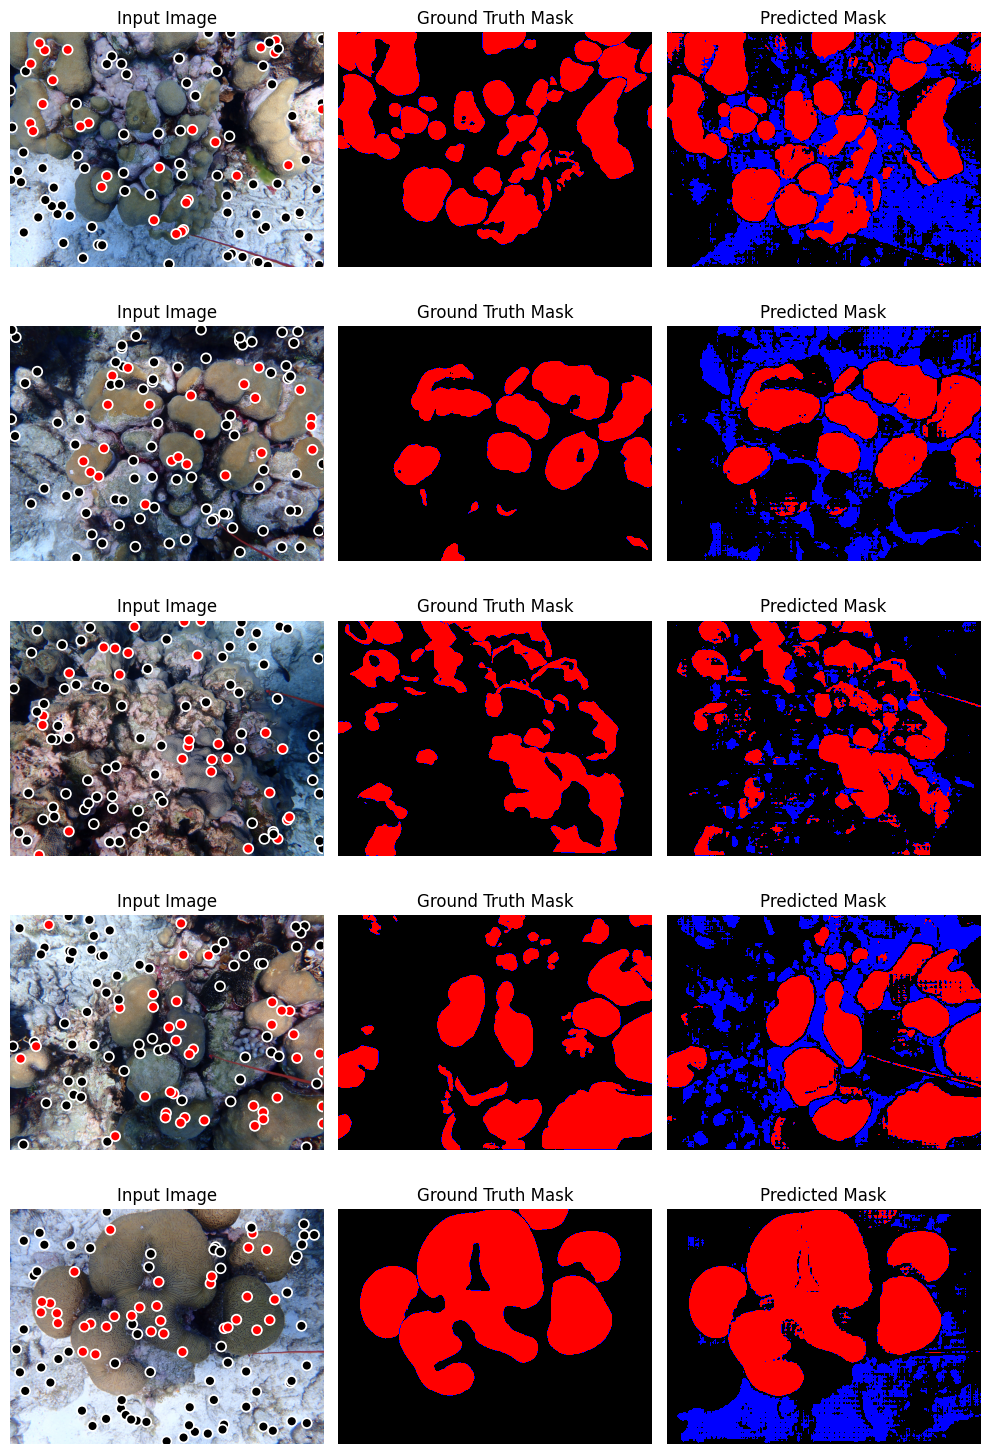

In [ ]:
visualize(model=sam, model_type="SAM", dataset=dl, num_images=5)

In [ ]:
sam_scores = eval_pipeline(dataset=dl, model=sam, model_type='SAM')

  0%|          | 0/100 [00:00<?, ?it/s]

mIoU score for SAM: 0.39190853177781826


### SAM 2

In [48]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


def load_sam2_model(model_type="sam2.1_hiera_large", model_cfg="configs/sam2.1/sam2.1_hiera_l.yaml"):
    """
    Loads a SAM2 model from a specified configuration and checkpoint file.

    Parameters:
    -----------
    model_type : str, optional
        Type of SAM2 model to load (e.g., 'sam2.1_hiera_large'). Defaults to 'sam2.1_hiera_large'.

    model_cfg : str, optional
        Idk what/why/how tbh... Defaults to "configs/sam2.1/sam2.1_hiera_l.yaml".

    Returns:
    --------
    SAM2ImagePredictor
        A SAM2ImagePredictor object initialized with the loaded SAM2 model.
    """
    checkpoint = f"../checkpoints/{model_type}.pt"

    sam2_model = build_sam2(model_cfg, checkpoint, device='cuda')
    predictor = SAM2ImagePredictor(sam2_model)
    return predictor


sam2 = load_sam2_model()

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


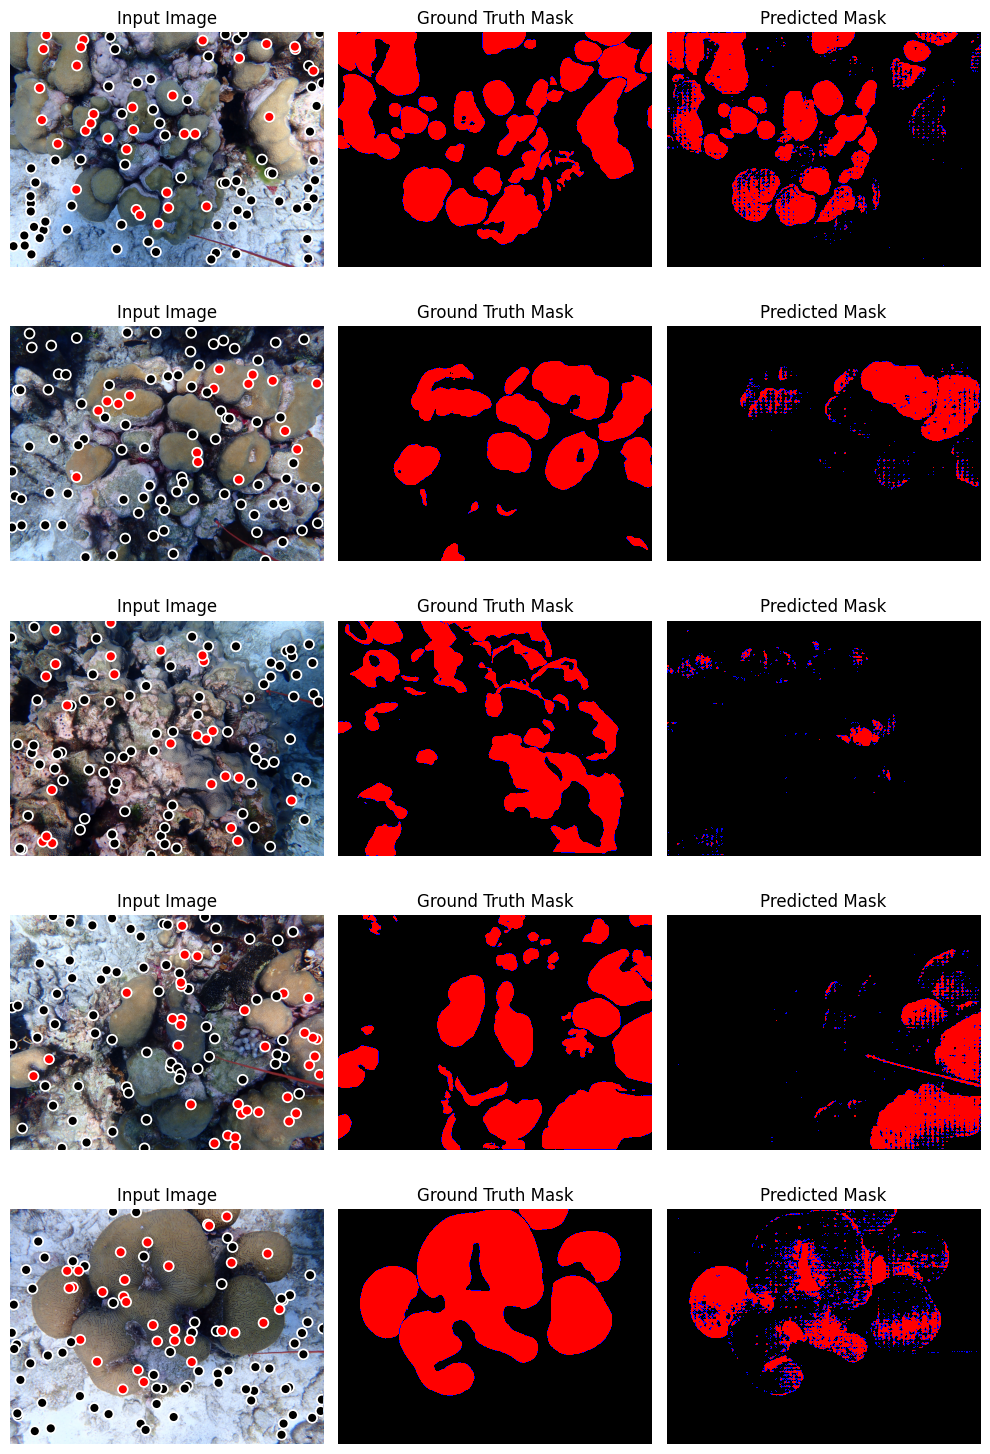

In [49]:
visualize(model=sam2, model_type="SAM", dataset=dl, num_images=5)

In [ ]:
sam2_scores = eval_pipeline(dataset=dl, model=sam2, model_type='SAM')

  0%|          | 0/483 [00:00<?, ?it/s]

mIoU score for SAM: 0.17092426722867007


### PLASPIX

In [ ]:
dl = DataLoader(SEAVIEW_PATH)

In [ ]:
PLASPIX_model = PLASPIX(superpix_model="SLIC", label_propagation_model="DISTANCE")

visualize(model=PLASPIX_model, model_type="PLASPIX", dataset=dl, num_images=5)